Attempting to load the kidney stone dataset...
Dataset successfully loaded!
Dataset Shape: (79, 7)

Column Names:
['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']

First few rows:
   gravity    ph  osmo  cond  urea  calc  target
0    1.021  4.91   725  14.0   443  2.45       0
1    1.017  5.74   577  20.0   296  4.49       0
2    1.008  7.20   321  14.9   101  2.36       0
3    1.011  5.51   408  12.6   224  2.15       0
4    1.005  6.52   187   7.5    91  1.16       0

Missing values:
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

Basic Statistics:
         gravity         ph         osmo       cond        urea       calc  \
count  79.000000  79.000000    79.000000  79.000000   79.000000  79.000000   
mean    1.018114   6.028481   612.848101  20.813924  266.405063   4.138987   
std     0.007239   0.724307   237.514755   7.938994  131.254550   3.260051   
min     1.005000   4.760000   187.000000   5.100000   10.000000

C:\Users\Aru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


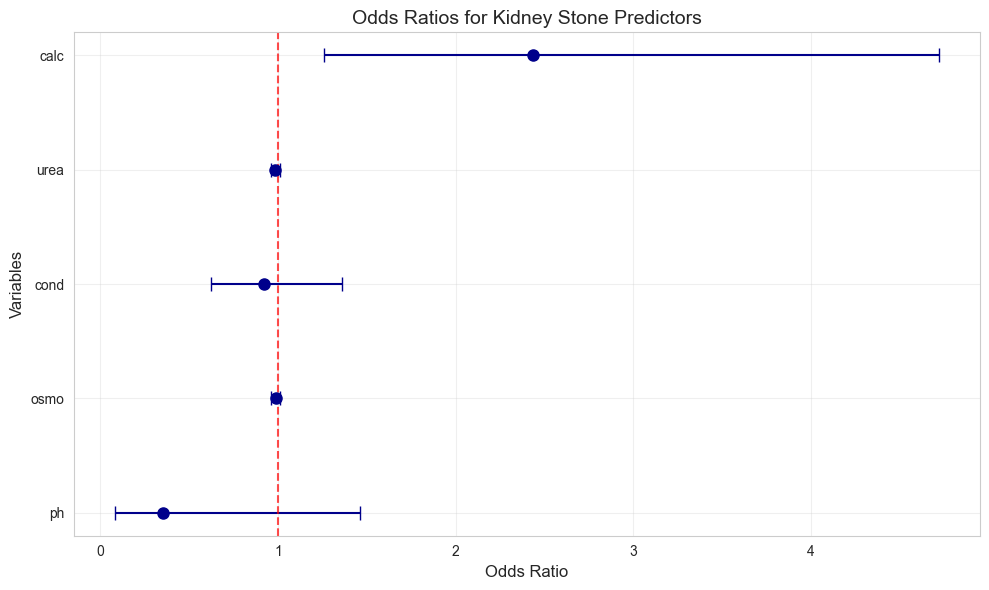

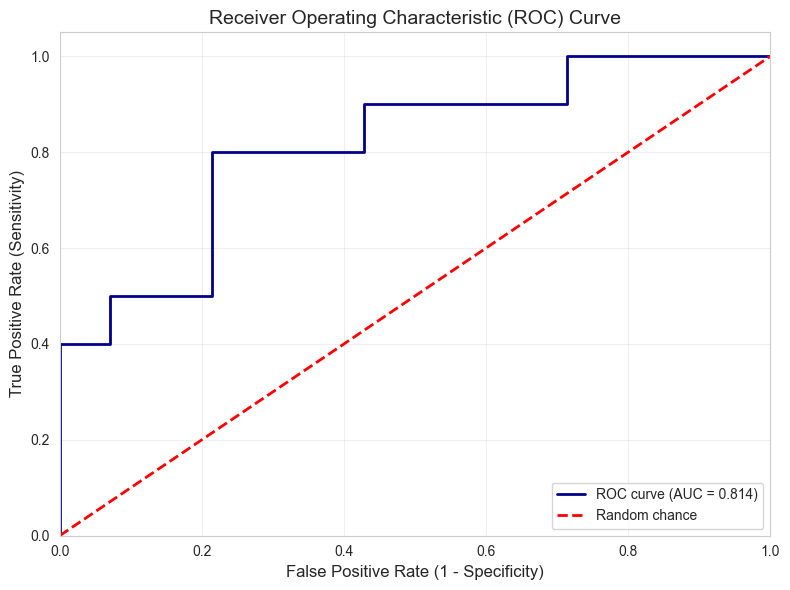

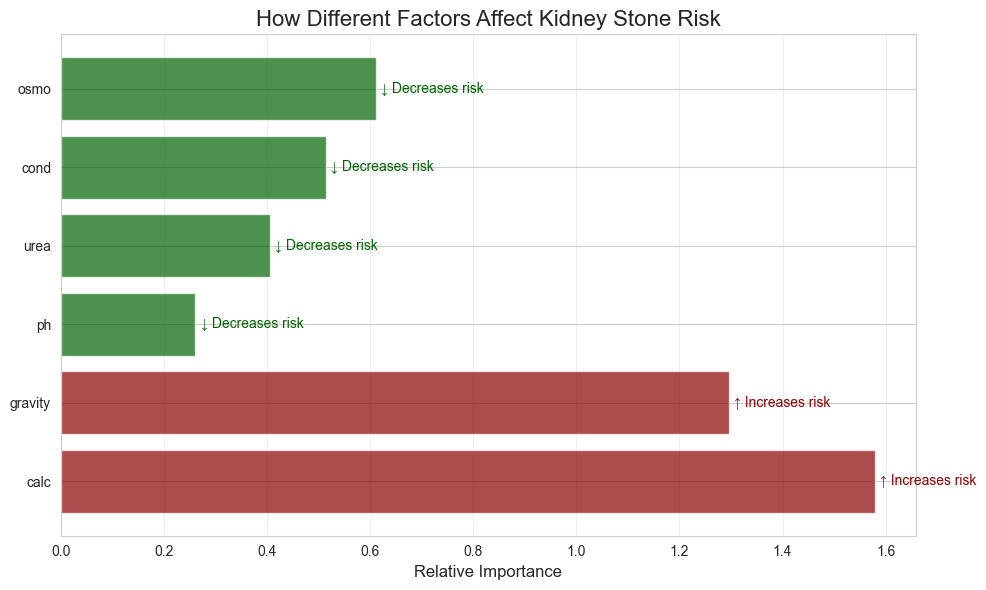

C:\Users\Aru\AppData\Local\Temp\ipykernel_9104\2554255365.py:308: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_actual = test_results.groupby('Risk Level')['Actual'].mean() * 100


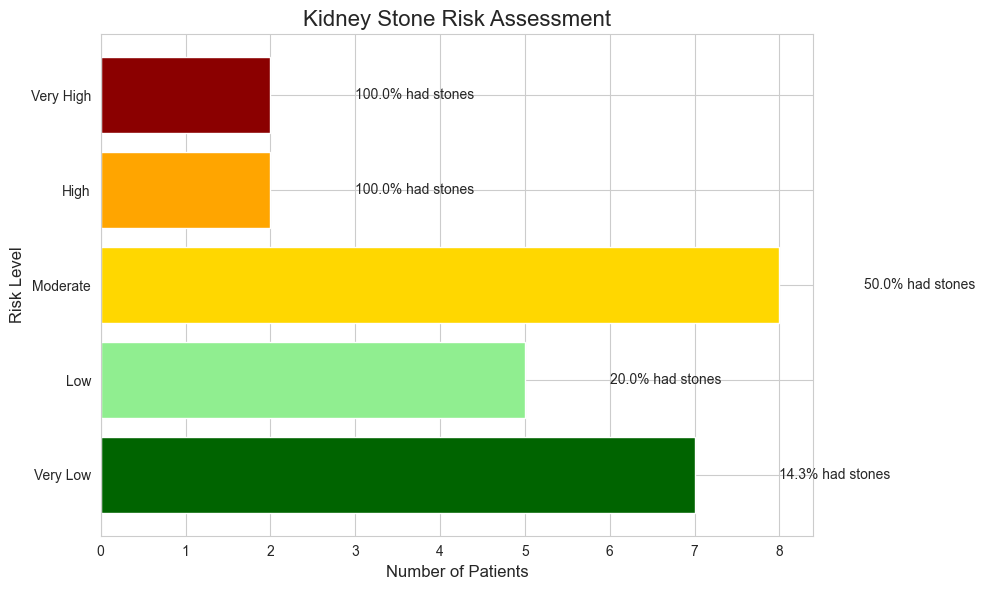


Analysis complete. Visualizations have been saved.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

# For reproducibility
np.random.seed(42)

# Sample data generation - this will be replaced with actual data if available
def generate_sample_data():
    n_samples = 200
    # Create synthetic features
    gravity = np.random.normal(1.015, 0.008, n_samples)
    ph = np.random.normal(6.0, 0.8, n_samples)
    osmo = np.random.normal(590, 170, n_samples)
    cond = np.random.normal(22, 7, n_samples)
    urea = np.random.normal(350, 120, n_samples)
    calc = np.random.normal(8.5, 3.5, n_samples)
    
    # Create synthetic relationships
    logit = (-15 + 
             5 * gravity + 
             -0.3 * ph + 
             0.005 * osmo + 
             0.1 * cond + 
             0.001 * urea + 
             0.3 * calc)
    
    # Convert to probabilities using the logistic function
    prob = 1 / (1 + np.exp(-logit))
    
    # Generate target variable (1 = stone present, 0 = no stone)
    target = np.random.binomial(1, prob)
    
    # Create a DataFrame with all variables
    data = pd.DataFrame({
        'gravity': gravity,
        'ph': ph,
        'osmo': osmo,
        'cond': cond,
        'urea': urea,
        'calc': calc,
        'target': target
    })
    
    return data

# Try to load the actual data, fall back to sample data if not available
try:
    print("Attempting to load the kidney stone dataset...")
    data = pd.read_csv(r"C:\Users\Aru\Downloads\archive (1)\kindey stone urine analysis.csv")
    print("Dataset successfully loaded!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Generating sample data instead.")
    data = generate_sample_data()

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\nColumn Names:")
print(data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(data.describe())

# Check class distribution (if 'target' column exists)
if 'target' in data.columns:
    print("\nClass Distribution:")
    print(data['target'].value_counts())
    print(f"Percentage of stone presence: {data['target'].mean()*100:.2f}%")

# Ensure the expected columns exist, or create appropriate mappings
expected_columns = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target']
column_mapping = {}

# Determine which columns to use for analysis
for expected in expected_columns:
    # Try to find exact matches
    if expected in data.columns:
        column_mapping[expected] = expected
    else:
        # Try to find partial matches
        matches = [col for col in data.columns if expected.lower() in col.lower()]
        if matches:
            column_mapping[expected] = matches[0]
        # Otherwise leave it unmapped

# Report on column mapping
print("\nColumn Mapping:")
for expected, actual in column_mapping.items():
    print(f"Using '{actual}' for '{expected}'")

# Extract features and target based on mapping
feature_cols = [column_mapping[col] for col in ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'] 
                if col in column_mapping]

if 'target' in column_mapping:
    target_col = column_mapping['target']
    X = data[feature_cols]
    y = data[target_col]
    
    # Check for extreme or problematic values in features
    print("\nChecking for extreme values in features:")
    for col in feature_cols:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((data[col] < lower_bound) | (data[col] > upper_bound)).sum()
        print(f"{col}: {outliers} potential outliers detected")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit the logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = model.predict(X_test_scaled)
    
    # Model evaluation
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"\nAUC: {auc:.3f}")
    
    # Get feature coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_[0],
        'Odds Ratio': np.exp(model.coef_[0])
    })
    coef_df = coef_df.sort_values('Coefficient', ascending=False)
    print("\nFeature Coefficients and Odds Ratios:")
    print(coef_df)
    
    # Try using statsmodels for detailed statistical output
    try:
        X_train_sm = sm.add_constant(X_train)
        sm_model = sm.Logit(y_train, X_train_sm)
        sm_results = sm_model.fit(disp=0)  # disp=0 suppresses convergence messages
        print("\nDetailed Statistical Results:")
        print(sm_results.summary())
        
        # Extract confidence intervals for odds ratios
        params = sm_results.params
        conf = sm_results.conf_int()
        conf.columns = ['Lower CI', 'Upper CI']
        conf_df = pd.concat([params, conf], axis=1)
        conf_df = conf_df.iloc[1:]  # Remove the constant
        conf_df.index.name = 'Feature'
        conf_df.reset_index(inplace=True)
        conf_df['Odds Ratio'] = np.exp(conf_df[0])
        conf_df['Lower OR'] = np.exp(conf_df['Lower CI'])
        conf_df['Upper OR'] = np.exp(conf_df['Upper CI'])
        
    except PerfectSeparationError:
        print("\nPerfect separation detected in the data. Using sklearn coefficients only.")
        conf_df = coef_df.copy()
        conf_df['Lower OR'] = np.nan
        conf_df['Upper OR'] = np.nan
    except Exception as e:
        print(f"\nError in statsmodels fitting: {e}")
        print("Using sklearn coefficients only.")
        conf_df = coef_df.copy()
        conf_df['Lower OR'] = np.nan
        conf_df['Upper OR'] = np.nan
    
    # ---------------- VISUALIZATIONS ----------------
    
    # 1. MEDICAL AUDIENCE VISUALIZATION: Forest Plot of Odds Ratios
    plt.figure(figsize=(10, 6))
    
    # For features with defined confidence intervals
    valid_features = conf_df[~conf_df['Lower OR'].isna() & ~np.isinf(conf_df['Lower OR']) & 
                            ~conf_df['Upper OR'].isna() & ~np.isinf(conf_df['Upper OR'])]
    
    if len(valid_features) > 0:
        # Create y-position for each feature
        y_pos = range(len(valid_features))
        
        # Plot odds ratios and confidence intervals
        plt.errorbar(
            valid_features['Odds Ratio'], 
            y_pos,
            xerr=[valid_features['Odds Ratio'] - valid_features['Lower OR'], 
                  valid_features['Upper OR'] - valid_features['Odds Ratio']],
            fmt='o', 
            capsize=5, 
            color='darkblue', 
            markersize=8
        )
        
        # Add feature names
        plt.yticks(y_pos, valid_features['Feature'])
    else:
        # Fall back to plotting just the odds ratios without CIs
        y_pos = range(len(conf_df))
        plt.scatter(conf_df['Odds Ratio'], y_pos, color='darkblue', s=80)
        plt.yticks(y_pos, conf_df['Feature'])
    
    # Add vertical line at OR = 1 (no effect)
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
    
    # Format plot without using log scale to avoid overflow errors
    plt.xlabel('Odds Ratio', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Odds Ratios for Kidney Stone Predictors', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Ensure the plot fits within the figure bounds
    plt.tight_layout()
    plt.savefig('medical_forest_plot.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to avoid display issues
    
    # 2. MEDICAL AUDIENCE VISUALIZATION: ROC Curve with AUC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('medical_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to avoid display issues
    
    # 3. LAY AUDIENCE VISUALIZATION: Simple Risk Factors Bar Chart
    plt.figure(figsize=(10, 6))
    
    # Use absolute values for bar heights
    abs_coefs = np.abs(coef_df['Coefficient'].values)
    colors = ['darkred' if c > 0 else 'darkgreen' for c in coef_df['Coefficient']]
    
    bars = plt.barh(coef_df['Feature'], abs_coefs, color=colors, alpha=0.7)
    
    # Add direction indicators as text
    for i, bar in enumerate(bars):
        if coef_df['Coefficient'].iloc[i] > 0:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, '↑ Increases risk', 
                     va='center', fontsize=10, color='darkred')
        else:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, '↓ Decreases risk', 
                     va='center', fontsize=10, color='darkgreen')
    
    plt.title('How Different Factors Affect Kidney Stone Risk', fontsize=16)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('lay_risk_factors.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to avoid display issues
    
    # 4. LAY AUDIENCE VISUALIZATION: Simplified Risk Score Meter
    # Create a categorical risk metric
    test_results = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted Probability': y_pred_prob
    })
    
    # Create bins for risk probabilities
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
    test_results['Risk Level'] = pd.cut(test_results['Predicted Probability'], bins=bins, labels=labels)
    
    # Count samples in each risk category
    risk_counts = test_results['Risk Level'].value_counts().sort_index()
    
    # Calculate actual stone prevalence in each category
    risk_actual = test_results.groupby('Risk Level')['Actual'].mean() * 100
    
    # Plot as a horizontal bar chart
    plt.figure(figsize=(10, 6))
    colors = ['darkgreen', 'lightgreen', 'gold', 'orange', 'darkred']
    
    # Ensure we only plot categories that exist in the data
    available_categories = risk_counts.index.tolist()
    colors = colors[:len(available_categories)]
    
    plt.barh(available_categories, risk_counts.values, color=colors)
    
    # Add percentages to the bars
    for i, (category, count) in enumerate(zip(available_categories, risk_counts.values)):
        if category in risk_actual.index:
            pct = risk_actual[category]
            plt.text(count + 1, i, f"{pct:.1f}% had stones", va='center')
    
    plt.title('Kidney Stone Risk Assessment', fontsize=16)
    plt.xlabel('Number of Patients', fontsize=12)
    plt.ylabel('Risk Level', fontsize=12)
    plt.tight_layout()
    plt.savefig('lay_risk_meter.png', dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot interactively
    plt.close()  # Close the figure to avoid display issues
    
    print("\nAnalysis complete. Visualizations have been saved.")
else:
    print("\nCould not identify the target variable in the dataset. Analysis stopped.")

This statistical analysis amongst individuals testing for presence of kidney stones has shown that the highest predictor of kidney stones is excess calcium. 
Amongst individuals who had moderate, high, and very high risk of kidney stones, half or greater had kidney stones. 
Even amongst individuals who very low and low risk of kidney stones, between 1 in 7, and 1 in 5 individuals had kidney stones. 
Research has shown that kidney stone risk increases with diets containing excess meat consumption, and diets containing little hydration and produce consumption. 